<a href="https://colab.research.google.com/github/AlirezaAhadipour/ECG_Heartbeat_Classification/blob/main/notebooks/ECG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install -r ../requirements.txt

In [3]:
# The following downloads the file directly from Kaggle. The credit for this code goes to ChatGPT!

import os

!pip install -q kaggle

# Set up Kaggle API
from google.colab import files

print("Please upload your kaggle.json file")
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

data_path = "/content/heartbeat_data"
!kaggle datasets download -d shayanfazeli/heartbeat -p /content/heartbeat_data --unzip


Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
 81% 80.0M/98.8M [00:00<00:00, 225MB/s]
100% 98.8M/98.8M [00:00<00:00, 210MB/s]


In [4]:
## import required libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
## set random seeds to make results reproducible
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


I'll use `mitbih_train.csv` as the training set, which I'll break into train and validation sets, and use the `mitbih_test.csv` as the test set. I'll leave `ptbdb_normal.csv` and `ptbdb_abnormal.csv` as a holdout set.

In [6]:
# # file paths
train_path = "heartbeat_data/mitbih_train.csv"
test_path = "heartbeat_data/mitbih_test.csv"

# load the data
df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

# first few rows
df_train.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A typical heartbeat is about 0.8 sec which is equal to 100 samples at a 125Hz sampling rate. The idea to extend that to 187 samples (or 1.5 sec equivalently) can be to also capture some surraounding context!

Next, let's verify that the last column is the targer (label) column. It should have 5 distinc values as `['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]`

In [7]:
df_train[187].unique()

array([0., 1., 2., 3., 4.])

In [8]:
# rename columns
num_features = df_train.shape[1] - 1
col_names = {i: f"feature_{i}" for i in range(num_features)}
col_names[num_features] = 'label'

df_train.rename(columns=col_names, inplace=True)
df_test.rename(columns=col_names, inplace=True)

df_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_train.shape

(87554, 188)

# Task 1: Data Processing

For this task, I limit everything to the training set and won't touch the test set to avoid any data leakage!

## EDA

In [10]:
# basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, feature_0 to label
dtypes: float64(188)
memory usage: 125.6 MB


In [11]:
print(f"# missing values: {df_train.isnull().sum().sum()}")

# missing values: 0


So far, it seems there is no missing values in the data, unless they are replaced by some specific values. we can plot the sequence and verify that. To do so, I'll plot 3 samples per class

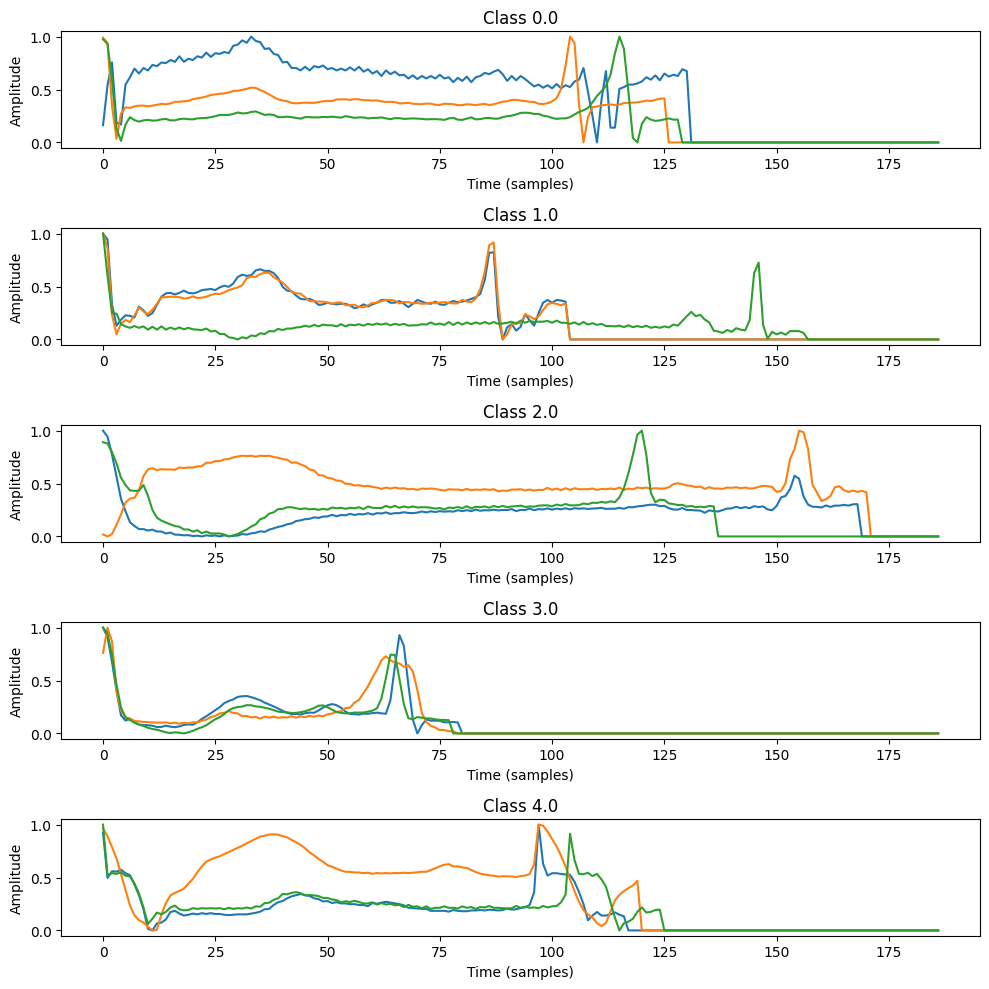

In [12]:
classes = df_train['label'].unique()
num_classes = len(classes)

fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 2*num_classes))

for i, label in enumerate(classes):
    samples = df_train[df_train['label'] == label].sample(3).iloc[:, :-1]

    for sample in samples.values:
        axes[i].plot(sample)

    axes[i].set_title(f"Class {label}")
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

plt.tight_layout()

There are paddings added to the end of each sequnce, but there is no visually obvious missing values that require being filled (emputed).

One thing that is bothering me is that I thought each segment captures the R-R interval, and if so, all sequences should start from the maximum value (which is 1), but it is not the case for all plots above!!!

label
0.0    82.77
4.0     7.35
2.0     6.61
1.0     2.54
3.0     0.73
Name: proportion, dtype: float64


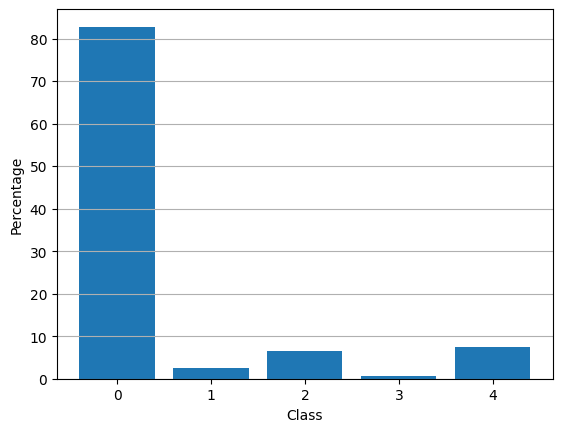

In [13]:
## class distribution
class_counts = df_train['label'].value_counts(normalize=True).mul(100).round(2)
print(class_counts)

# plot class distribution
plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.grid(axis='y')

So, the dataset is highly imbalanced, with the majority (~83%) being class 0 (`N`), and less than 1% for class 3 (`F`)

               mean       std
feature_0  0.890360  0.240909
feature_1  0.758160  0.221813
feature_2  0.423972  0.227305
feature_3  0.219104  0.206878
feature_4  0.201127  0.177058
feature_5  0.210399  0.171909
feature_6  0.205808  0.178481
feature_7  0.201773  0.177240
feature_8  0.198691  0.171778
feature_9  0.196757  0.168357


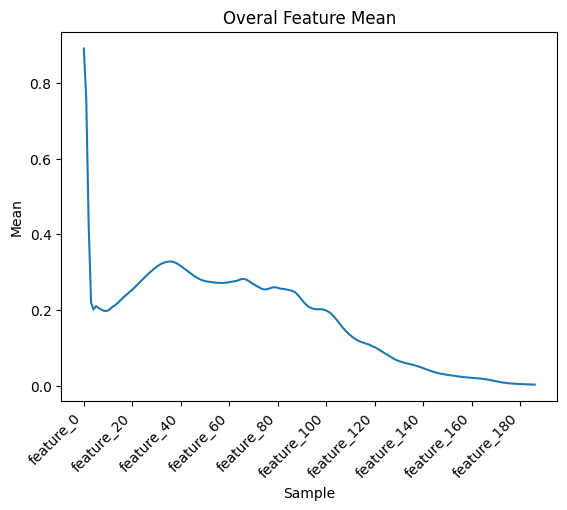

In [14]:
## feature statistics
feature_stats = df_train.drop(columns=['label']).describe()
feature_stats = feature_stats.T
feature_stats = feature_stats[['mean', 'std']]
print(feature_stats[:10])

# plot the mean
plt.plot(feature_stats.index, feature_stats['mean'])
plt.xlabel('Sample')
plt.ylabel('Mean')
plt.title('Overal Feature Mean')
plt.xticks(ticks=range(0, 187, 20), rotation=45, ha='right')
plt.show()

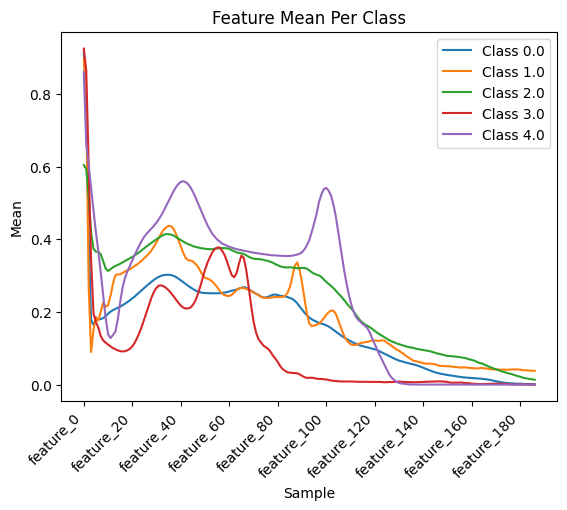

In [15]:
## per class
feature_stats_per_class = df_train.groupby('label').mean().T

for cls in df_train['label'].unique():
    plt.plot(feature_stats_per_class.index, feature_stats_per_class[cls], label=f"Class {cls}")

plt.xlabel('Sample')
plt.ylabel('Mean')
plt.xticks(ticks=range(0, 187, 20), rotation=45, ha='right')
plt.title('Feature Mean Per Class')
plt.legend()


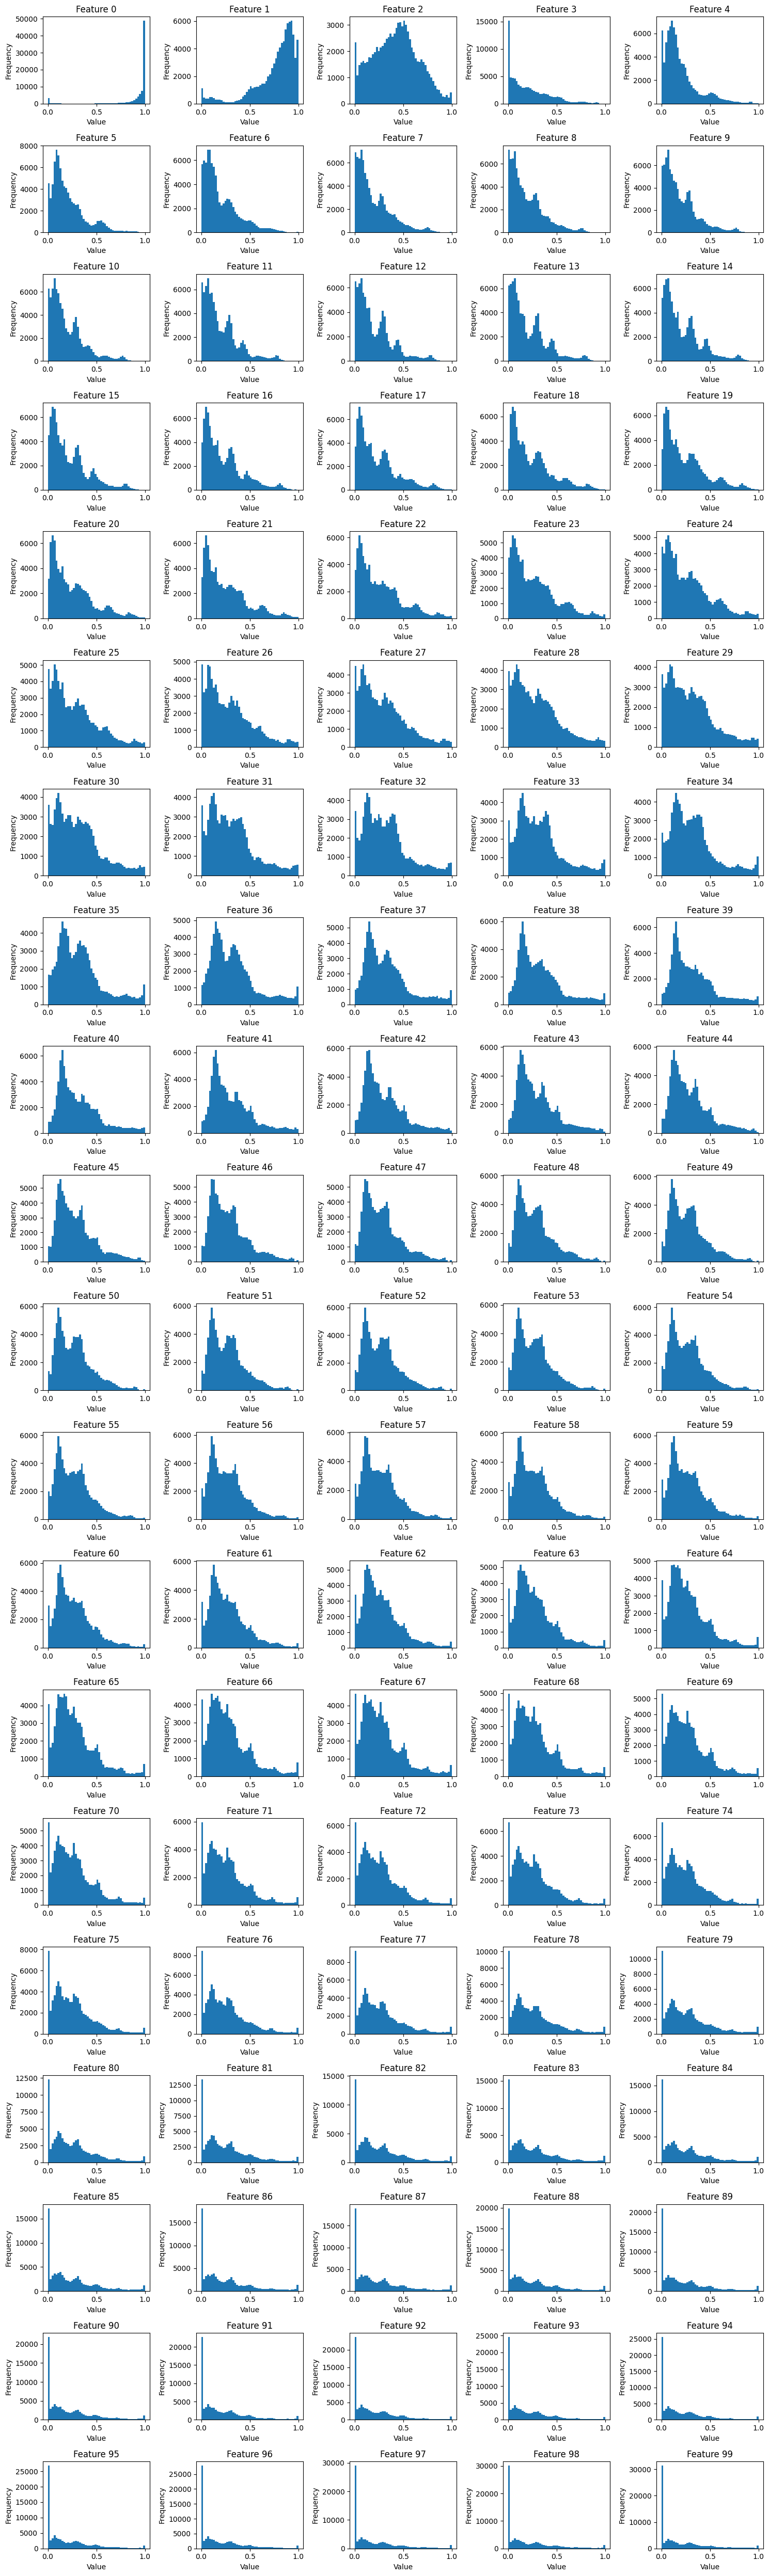

In [16]:
## feature distribution
feature_subset = df_train.drop(columns=['label']).iloc[:, :100]  # first 100 features
fig, axes = plt.subplots(20, 5, figsize=(15, 50))

for i, ax in enumerate(axes.flat):
    ax.hist(feature_subset.iloc[:, i], bins=50)
    ax.set_title(f"Feature {i}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()

Next, let's see if there is any correlation between different features

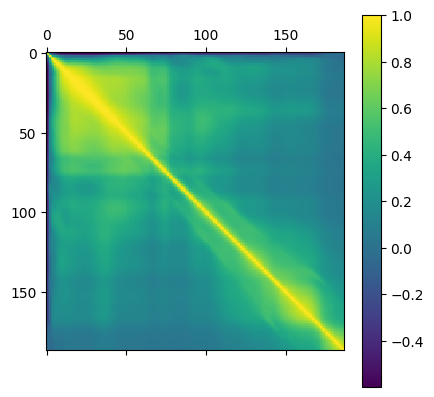

In [17]:
## feature correlation
corr = df_train.drop(columns=['label']).corr()

# plot
plt.matshow(corr)
plt.colorbar()

plt.tight_layout()

As expected, there is a strong diagonal correlation, since each feature is perfectly correlated with itself. The heatmap also reveals a strong correlation among the first ~60 features (among all classes), indicating similar signal patterns in that range. Additionally, features that are closer together tend to have higher correlation than those further apart, which is expected in time-series data.

We can visualize it further per class

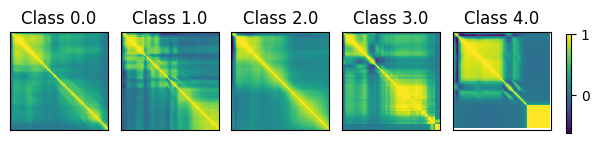

In [18]:
## per class
classes = df_train['label'].unique()

fig, axes = plt.subplots(1, len(classes))

for i, cls in enumerate(classes):
    corr = df_train[df_train['label'] == cls].drop(columns=['label']).corr()

    im = axes[i].matshow(corr)
    axes[i].set_title(f"Class {cls}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.colorbar(im, ax=axes, fraction=0.01, pad=-0.15)
plt.tight_layout()


We can see that feature correlations vary significantly across different classes, indicating that different classes have distinct dependencies among features

## Data Augmentation

As seen before, the dataset is highly imbalanced. While data augmentation increases the number of training examples, it does not balance the dataset. However, by generating variations of underrepresented classes, it can help the model generalize better and reduce overfitting.

One straightforward yet effective time-series augmentation technique is adding Gaussian noise to the signal (jittering). This method is minimally invasive, while making the model more robust to noise. If applied with an appropriate noise level, it is unlikely to shift a signal from one class to another. So the level of noise is a hyper parameter itself to be effective while not distorting the data

$$
x_i' = x_i + \mathcal{N}(0, \sigma)
$$

A critical point to consider is that both the original signal and its augmented version must reside in the same dataset, either training or validation. Otherwise, data leakage can occur, where information from the training set affects validation performance, leading to optimistic results.

In [19]:
# split into train and val sets
train_set, val_set = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

# std
feature_std = train_set.drop(columns=['label']).replace(0, np.nan).std().mean()

# noise level
sigma = 0.01 * feature_std

def augment_signal(signal, sigma):
    augmented_signal = signal.copy()
    nonzero_indx = np.where(signal != 0)[0]  # non-padded index

    noise = np.random.normal(0, sigma, size=len(nonzero_indx))
    augmented_signal[nonzero_indx] += noise

    # min-max scale
    min_val = augmented_signal[nonzero_indx].min()
    max_val = augmented_signal[nonzero_indx].max()
    augmented_signal[nonzero_indx] = (augmented_signal[nonzero_indx] - min_val) / (max_val - min_val)

    return augmented_signal

train_augmented = train_set.copy()
for i in range(train_augmented.shape[0]):
    train_augmented.iloc[i, :-1] = augment_signal(train_augmented.iloc[i, :-1].values, sigma)


final_train_set = pd.concat([train_set, train_augmented], ignore_index=True)
final_train_set.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,label
0,0.053191,0.162234,0.292553,0.441489,0.521277,0.627660,0.747340,0.784574,0.779255,0.795213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.974265,0.867647,0.591912,0.312500,0.128676,0.022059,0.000000,0.014706,0.044118,0.055147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.752322,0.637771,0.540248,0.411765,0.272446,0.151703,0.086687,0.023220,0.024768,0.043344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.977654,0.916201,0.614525,0.364991,0.327747,0.294227,0.240223,0.210428,0.178771,0.152700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015464,0.000000,0.033505,0.108247,0.203608,0.269330,0.349227,0.444588,0.511598,0.600515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


To recap, I set the noise level to 1% of the signal variations, as the goal is to add noise to the fluctuations in the signal, not the introduce new bumps. Next, split the training data to train and validation set to apply jitter to the train set only. Then, I extracted the non-padded part of the signals and add noise to those sections only, and then mapped the back between 0 and 1 incase they exceeded that range.

If time permits, I would change the noise level to see how that would affect the performance of the model.

In [20]:
df_train.shape, train_set.shape, train_augmented.shape, final_train_set.shape

((87554, 188), (70043, 188), (70043, 188), (140086, 188))

## Feature Engineering

We can extract statistical features that represent each ECG segment, such as mean, median, standard deviation, skewness, kurtosis, autocorrelation, and entropy measures (e.g., sample or permutation entropy). These features can then be used to train a traditional classification model.

However, as a starting point, I prefer to leverage deep learning models, which can automatically learn relevant features from the raw data, rather than relying on manually engineered features.

## Handle Missing Values

In [21]:
print(f"# missing values, train set: {df_train.isnull().sum().sum()}")
print(f"# missing values, test set: {df_test.isnull().sum().sum()}")

# missing values, train set: 0
# missing values, test set: 0


As can be seen, there are no missing values in the training and test sets; however if missing values were present, different strategies would be needed depending on their distribution:
- if missing values are sparse and isolated, we can simply fill them using linear interpolation
- if there are consecutive missing values (gaps), depending on the length of the gap, we can either fill them using linear (or spline) interpolation for example (or even use more advanced techniques like training ARIMA or LSTM models to predict the missing values (fill the gaps)), or if the gap is too large and filling will introduce too much uncertainty, simply dropping those samples might be a better choice

# Task 2: Model Training & Fine-tuning

As mentioned before, I did not perform any feature engineering and decided to start with deep learning models which are pretty good at feature extraction. Since we are dealing with raw ECG signals, a CNN (Convolutional Neural Net) would be a great choice as it automatically extract features from raw signal and can capture local patterns in the signal. To be more specific, I'll start with a 1D-CNN (1 Dimensional CNN) model. If CNN does not perform well enough, we can add an LSTM layer on the top to capture the temporal dependencies based on the captures extracted by the CNN.

In [22]:
## prepare data for training
X_train = final_train_set.iloc[:, :-1].values
y_train = final_train_set.iloc[:, -1].values
y_train_copy = y_train.copy()   # create a copy for later use in calculating the class weight

X_val = val_set.iloc[:, :-1].values
y_val = val_set.iloc[:, -1].values

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# reshape (samples, time_steps, channels)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# convert labels to categorical
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

Let's start with a base model, which is simply two layers of CNN stacking on top of each other, and see how it performs, and if needed, add more components to the model to improve the performance later on

In [23]:
# CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

print(model.summary())


# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              # optimizer=SGD(learning_rate=0.001, nesterov=True, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32)

# save the model
model.save('models/cnn_base.h5')

Epoch 1/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 163s 37ms/step - accuracy: 0.9404 - loss: 0.2249 - val_accuracy: 0.9720 - val_loss: 0.0966
Epoch 2/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 202s 37ms/step - accuracy: 0.9760 - loss: 0.0854 - val_accuracy: 0.9780 - val_loss: 0.0812
Epoch 3/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 207s 38ms/step - accuracy: 0.9808 - loss: 0.0662 - val_accuracy: 0.9832 - val_loss: 0.0711
Epoch 4/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 202s 38ms/step - accuracy: 0.9846 - loss: 0.0519 - val_accuracy: 0.9831 - val_loss: 0.0707
Epoch 5/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 202s 38ms/step - accuracy: 0.9870 - loss: 0.0439 - val_accuracy: 0.9763 - val_loss: 0.0948
Epoch 6/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 202s 37ms/step - accuracy: 0.9879 - loss: 0.0386 - val_accuracy: 0.9845 - val_loss: 0.0783
Epoch 7/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 198s 37ms/step - accuracy: 0.9890 - loss: 0.0351 - val_accuracy: 0.9823 - val_loss: 0.0906
Epoch 8/10
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 204s 37ms/step - accuracy: 

685/685 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.94      0.73      0.82       556
           2       0.96      0.94      0.95      1448
           3       0.74      0.79      0.77       162
           4       0.98      0.99      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.92      0.89      0.90     21892
weighted avg       0.98      0.98      0.98     21892



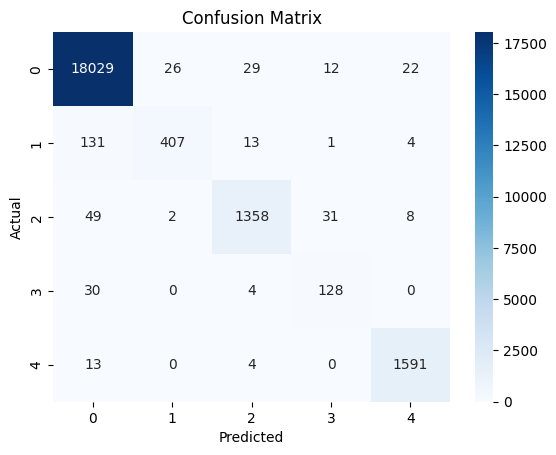

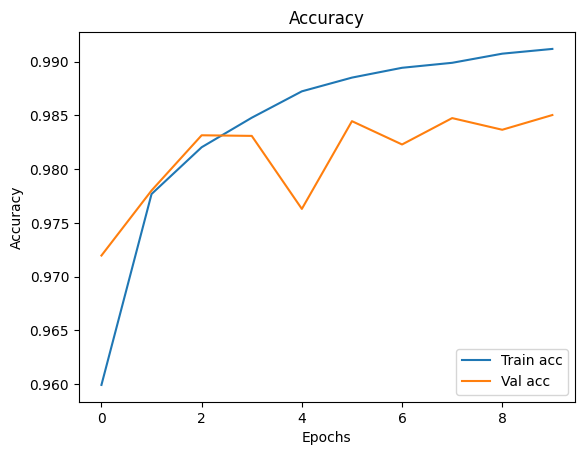

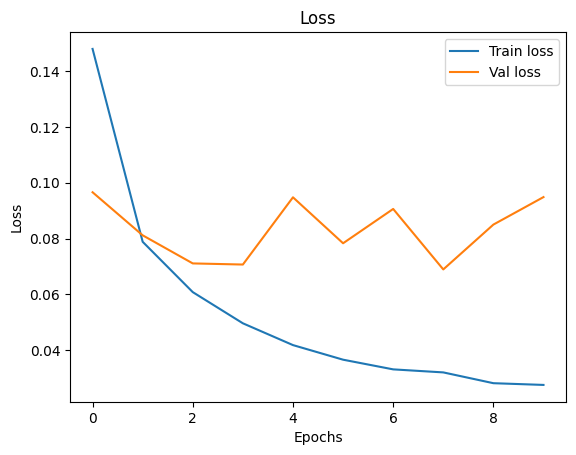

In [24]:
## evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrix
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Learning curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()


The overall performance is quite good for the first attempt. However, the model struggles with classes 1 and 3, which was expected because these classes have the fewest training examples. So, the model hasn't seen enough samples from these categories, making it harder to classify them correctly.

Since the dataset is highly imbalanced, the accuracy metric alone does not tell the full story and can even be misleading. A model can achieve high accuracy simply by predicting the majority class most of the time while still failing to classify minority classes correctly. And usually, minority classes are the ones that we are interested in!

To get a more reliable evaluation, we should consider the F1-score, which balances precision and recall. This metric is particularly important in imbalanced classification problems because it ensures that both false positives and false negatives are accounted for, rather than just looking at overall correctness.

Looking at the accuracy plot, we observe a performance gap between training and validation accuracy. However, this is not necessarily overfitting! It is expected that a model performs better on the samples it has seen during training than on unseen validation data. Overfitting occurs when the model performs exceptionally well on the training set but poorly on the validation/test set. In this case, the model's performance on validation set is still acceptable, so overfitting does not seem to be a major concern at this stage.

To improve classification performance, especially for underrepresented classes, I will:
- Apply class weighting to give more importance to minority classes, ensuring misclassification penalties are higher for them
- Reduce the learning rate to help the model converge more smoothly
- Increase the number of training epochs to allow better learning
- Add early stopping to prevent overfitting

Early stopping monitors validation loss during training. If the performance stops improving or begins to deteriorate, training is automatically stopped and the model returns the best weights recorded during training.

In [25]:
# compute class weights
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train_copy),y=y_train_copy)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

# save the model
model.save('models/cnn_es.h5')

Epoch 1/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 169s 38ms/step - accuracy: 0.6832 - loss: 0.6388 - val_accuracy: 0.8701 - val_loss: 0.3606
Epoch 2/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 199s 37ms/step - accuracy: 0.8503 - loss: 0.2982 - val_accuracy: 0.9036 - val_loss: 0.2729
Epoch 3/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 205s 38ms/step - accuracy: 0.8840 - loss: 0.2221 - val_accuracy: 0.9222 - val_loss: 0.2217
Epoch 4/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 203s 38ms/step - accuracy: 0.9051 - loss: 0.1772 - val_accuracy: 0.9203 - val_loss: 0.2217
Epoch 5/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 202s 38ms/step - accuracy: 0.9191 - loss: 0.1376 - val_accuracy: 0.9295 - val_loss: 0.2069
Epoch 6/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 205s 39ms/step - accuracy: 0.9320 - loss: 0.1188 - val_accuracy: 0.9268 - val_loss: 0.2279
Epoch 7/50
 504/4378 ━━━━━━━━━━━━━━━━━━━━ 2:22 37ms/step - accuracy: 0.9457 - loss: 0.1032

KeyboardInterrupt: 

As we can see, we set the number of epochs for training to 50, but the early stopping terminated the training after 21 epochs only! If we take a closer look, we can see that the validation loss started to increase after epoch 16, which means the model started to overfit. As I set the patience to 5 epochs, it waited for 5 epochs to see if the loss started to decrease again or not, and if not, terminate the training.

In [ ]:
## evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# classification report
print(classification_report(y_true_classes, y_pred_classes))

# confusion matrix
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Learning curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
print(class_weights_dict)

First, by looking at the class weights, we see that the weight that the model gave to each class is proportionate to the scarcity of those classes in the training set, for example, class 3 has 100+ times more weight than class 0.

So, I expected that it would improve the performance for classes 1 and 3. But honestly, I did not expect the outcome!!! I expected giving more weight to the under-represented classes would improve their outcome, but by comparing to the base model's performance, for 3rd class for instance, the precision dropped from 83% to 58%, but recall improved a little bit (from 77% for the base model to 82%) and the F1-score dropped from 80% Overall, the F1-score dropped from 80% to 68%.

## Hyperparameter Tuning

There are a couple of parameters we can tune to improve the performance of the model such as
- number of filters
- kernel size
- activation function
- dropout rate
- learning rate
- optimization function (SGD, Adam)
- batch size

A straightforward approach for hyperparameter tuning is **Grid Search**, which provides full control over the search process. However, its major drawback is that it can be computationally expensive and inefficient when the search space is large. In such cases, more efficient methods like KerasTuner can be used, which optimize hyperparameters stochastically rather than exhaustively.

For the sake of simplicity, I implemented Grid Search as the following. Here, I just provided the code and it is working without any error, but I am not going to fully run it as it will take so long!

In [ ]:
# # hyperparameters
# param_grid = {
#     'filters': [32, 64, 128],
#     'kernel_size': [3, 5, 7],
#     'dropout_rate': [0.2, 0.3, 0.5],
#     'learning_rate': [0.0001, 0.001],
#     'batch_size': [32, 64]
# }


# param_combinations = list(itertools.product(*param_grid.values()))

# best_accuracy = 0
# best_params = None

# for params in param_combinations:
#     filters, kernel_size, dropout_rate, learning_rate, batch_size = params

#     # model
#     model = Sequential([
#         Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),

#         Conv1D(filters=filters*2, kernel_size=kernel_size, activation='relu'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),

#         Flatten(),
#         Dense(64, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(5, activation='softmax')
#     ])

#     # compile
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

#     # train
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_val, y_val),
#         epochs=10, batch_size=batch_size,
#         class_weight=class_weights_dict,
#         callbacks=[early_stopping],
#         verbose=0
#     )

#     # evaluate
#     val_accuracy = max(history.history['val_accuracy'])

#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_params = params

# print(f"Best parameters: {best_params} with validation accuracy: {best_accuracy:.2f}")


# Task 3: Testing Holdout Set

For this task, I'll use the `ptbdb_normal` and `ptbdb_abnormal` datasets as holdout sets, and use the base model for prediction/evaluation

In [31]:
# # file paths
holdout_normal_path = "heartbeat_data/ptbdb_normal.csv"
holdout_abnormal_path = "heartbeat_data/ptbdb_abnormal.csv"

# load the data
df_normal = pd.read_csv(holdout_normal_path, header=None)
df_abnormal = pd.read_csv(holdout_abnormal_path, header=None)

df_holdout = pd.concat([df_normal, df_abnormal], ignore_index=True)

# first few rows
df_holdout.head()


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# rename columns
num_features = df_holdout.shape[1] - 1
col_names = {i: f"feature_{i}" for i in range(num_features)}
col_names[num_features] = 'label'

df_holdout.rename(columns=col_names, inplace=True)

df_holdout.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,label
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_normal[187].unique(), df_abnormal[187].unique()

(array([0.]), array([1.]))

In [37]:
class_count = df_holdout['label'].value_counts()
print(class_count)

label
1.0    10506
0.0     4046
Name: count, dtype: int64


The holdout set contains only two classes, with the majority of samples belonging to the abnormal cases.

Let's first visualize a couple of samples before jumping to the evaluation of the model!

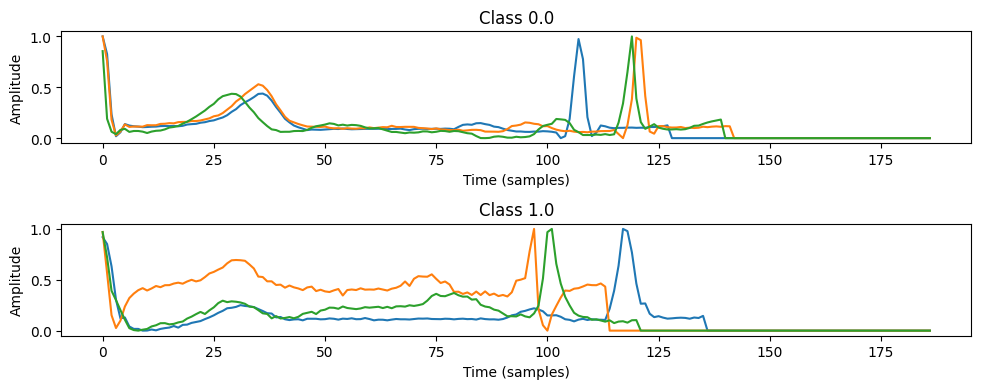

In [38]:
classes = df_holdout['label'].unique()
num_classes = len(classes)

fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 2*num_classes))

for i, label in enumerate(classes):
    samples = df_holdout[df_holdout['label'] == label].sample(3).iloc[:, :-1]

    for sample in samples.values:
        axes[i].plot(sample)

    axes[i].set_title(f"Class {label}")
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

plt.tight_layout()

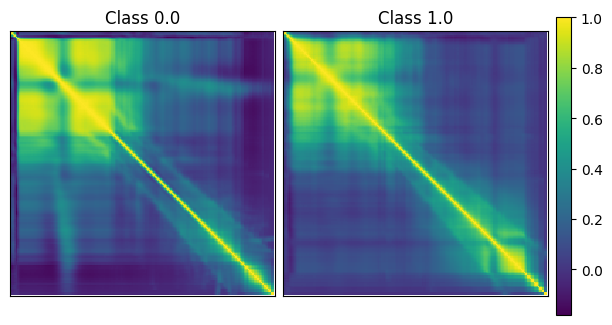

In [44]:
## feature correlation
classes = df_holdout['label'].unique()

fig, axes = plt.subplots(1, len(classes))

for i, cls in enumerate(classes):
    corr = df_holdout[df_holdout['label'] == cls].drop(columns=['label']).corr()

    im = axes[i].matshow(corr)
    axes[i].set_title(f"Class {cls}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.colorbar(im, ax=axes, fraction=0.03, pad=-0.175)
plt.tight_layout()


There are two possible approaches to applying the trained model to this dataset:
1. Modify the last Dense layer to perform binary classification instead of multi-class classification by replacing softmax with sigmoid, and then retrain the model on the holdout dataset. However, if the goal is to evaluate how the existing model handles a distribution shift, this approach wouldn’t be ideal since retraining alters the original model’s learned representations.
2. Use the model as-is and simply map the multi-class predictions to binary labels, where `{0 -> 0; 1, 2, 3, 4 -> 1}`. This preserves the original model's learning and allows us to analyze how well it generalizes to unseen data shifts, which aligns with the objective of this task.

In [54]:
# load the model
from tensorflow.keras.models import load_model

model = load_model('models/cnn_base.h5')

In [65]:
# feature and label
X_holdout = df_holdout.iloc[:, :-1].values
y_holdout = df_holdout.iloc[:, -1].values

# reshape
X_holdout = X_holdout.reshape((X_holdout.shape[0], X_holdout.shape[1], 1))

In [68]:
# predict (multi-class classification)
y_pred_prob = model.predict(X_holdout)
y_pred_multi = np.argmax(y_pred_prob, axis=1)

# map predictions to binary labels: 0 -> 0, {1,2,3,4}  1
y_pred_binary = (y_pred_multi != 0).astype(int)


455/455 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


              precision    recall  f1-score   support

         0.0       0.29      0.98      0.45      4046
         1.0       0.91      0.08      0.14     10506

    accuracy                           0.33     14552
   macro avg       0.60      0.53      0.30     14552
weighted avg       0.74      0.33      0.23     14552



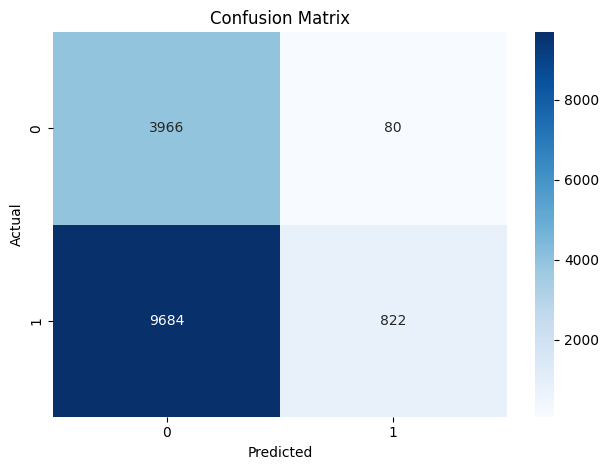

In [69]:
## evaluate
print(classification_report(y_holdout, y_pred_binary))

sns.heatmap(confusion_matrix(y_holdout, y_pred_binary), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

The overall performance of the model on the holdout set is significantly different from the validation and test results. While the model performed well on the majority class (Class 0), it struggled to classify abnormal cases (Class 1).

The holdout set results show:
- Class 0 (normal heartbeat): high recall but low precision
- Class 1 (abnormal heartbeats): high precision but very low recall, meaning the model frequently misclassifies abnormal heartbeats as normal

One possible reason for performance degradation is a shift in data distribution. If the holdout set comes from a different patient population the model may struggle to generalize. Even differences in ECG recording devices could contribute to this distribution shift.

# Task 4: Deployment Strategies